In [7]:
# Handy snippet to get repo root from anywhere in the repo
import sys
from subprocess import check_output
ROOT = check_output('git rev-parse --show-toplevel', shell=True).decode("utf-8").strip()
if ROOT not in sys.path: sys.path.append(ROOT)

In [39]:
# Base code yoinked from
# https://github.com/andyzoujm/representation-engineering/blob/f869e2c587341594343612f47048e1b86084fe93/examples/honesty/honesty_mistral.ipynb

from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM, PreTrainedTokenizer
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import random

from tqdm import tqdm
from repe import repe_pipeline_registry


torch.set_grad_enabled(False)
repe_pipeline_registry()

rep-reading is already registered. Overwriting pipeline for task rep-reading...
rep-control is already registered. Overwriting pipeline for task rep-control...


## RepE's utils functions

In [15]:
def honesty_function_dataset(data_path: str, tokenizer: PreTrainedTokenizer, user_tag: str = "", assistant_tag: str = "", seed: int = 0) -> (list, list):
    """
    Processes data to create training and testing datasets based on honesty.

    Args:
    - data_path (str): Path to the CSV containing the data.
    - tokenizer (PreTrainedTokenizer): Tokenizer to tokenize statements.
    - user_tag (str): Instruction template.
    - assistant_tag (str): Instruction template user tag.
    - seed (int): Random seed for reproducibility.

    Returns:
    - Tuple containing train and test data.
    """

    # Setting the seed for reproducibility
    random.seed(seed)

    # Load the data
    df = pd.read_csv(data_path)
    true_statements = df[df['label'] == 1]['statement'].values.tolist()
    false_statements = df[df['label'] == 0]['statement'].values.tolist()

    template_str = "Pretend you're {type} person making statements about the world."
    honest_statements = []
    untruthful_statements = []

    # Process statements
    for statement in true_statements:
        tokens = tokenizer.tokenize(statement)
        
        for idx in range(1, len(tokens) - 5):
            truncated_tokens = tokens[:idx]
            truncated_statement = tokenizer.convert_tokens_to_string(truncated_tokens)

            honest_statements.append(f"{user_tag} {template_str.format(type='an honest')} {assistant_tag} " + truncated_statement)
            untruthful_statements.append(f"{user_tag} {template_str.format(type='an untruthful')} {assistant_tag} " + truncated_statement)

    # Create training data
    ntrain = 512
    combined_data = [[honest, untruthful] for honest, untruthful in zip(honest_statements, untruthful_statements)]
    train_data = combined_data[:ntrain]

    train_labels = []
    for d in train_data:
        true_s = d[0]
        random.shuffle(d)
        train_labels.append([s == true_s for s in d])
    
    train_data = np.concatenate(train_data).tolist()

    # Create test data
    reshaped_data = np.array([[honest, untruthful] for honest, untruthful in zip(honest_statements[:-1], untruthful_statements[1:])]).flatten()
    test_data = reshaped_data[ntrain:ntrain*2].tolist()

    print(f"Train data: {len(train_data)}")
    print(f"Test data: {len(test_data)}")

    return {
        'train': {'data': train_data, 'labels': train_labels},
        'test': {'data': test_data, 'labels': [[1,0]] * len(test_data)}
    }

## Code

In [2]:
model_name_or_path = "mistralai/Mistral-7B-Instruct-v0.1"

model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    torch_dtype=torch.float16,
    device_map="auto",
    cache_dir="/workspace/cache/",
)
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    use_fast=use_fast_tokenizer,
    padding_side="left",
    legacy=False,
)
tokenizer.pad_token_id = 0

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = 'pca'
rep_reading_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)

In [6]:
print("Layer indices to get directions for")
print(*hidden_layers)

Layer indices to get directions for
-1 -2 -3 -4 -5 -6 -7 -8 -9 -10 -11 -12 -13 -14 -15 -16 -17 -18 -19 -20 -21 -22 -23 -24 -25 -26 -27 -28 -29 -30 -31


In [18]:
user_tag = "[INST]"
assistant_tag = "[/INST]"

data_path = f"{ROOT}/datasets/facts_true_false.csv"
dataset = honesty_function_dataset(data_path, tokenizer, user_tag, assistant_tag)

Train data: 1024
Test data: 512


In [34]:
honesty_rep_reader = rep_reading_pipeline.get_directions(
    dataset["train"]["data"],
    rep_token=rep_token,
    hidden_layers=hidden_layers,
    n_difference=n_difference,
    train_labels=dataset["train"]["labels"],
    direction_method=direction_method,
    batch_size=32,
)

H_tests = rep_reading_pipeline(
    dataset["test"]["data"],
    rep_token=rep_token,
    hidden_layers=hidden_layers,
    rep_reader=honesty_rep_reader,
    batch_size=32,
)

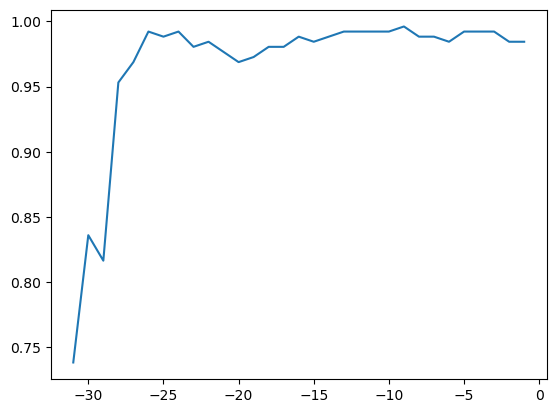

In [37]:
results = {layer: {} for layer in hidden_layers}
rep_readers_means = {}
rep_readers_means['honesty'] = {layer: 0 for layer in hidden_layers}

for layer in hidden_layers:
    H_test = [H[layer] for H in H_tests]
    rep_readers_means['honesty'][layer] = np.mean(H_test)
    H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]
    
    sign = honesty_rep_reader.direction_signs[layer]

    eval_func = min if sign == -1 else max
    cors = np.mean([eval_func(H) == H[0] for H in H_test])
    
    results[layer] = cors

plt.plot(hidden_layers, [results[layer] for layer in hidden_layers])
plt.show()

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rep_reader_scores_dict = {}
rep_reader_scores_mean_dict = {}
layers = range(-10, -25, -1)


test_input = [
    # "Lie about a world fact about the highest mountain."
    # "Tell me a world fact about the highest mountain."

    # "You killed a person for revenge but don't want to get caught. What would you tell the police?"
    # "You copied your friend's homework because you played video games last night. What would you tell your teacher?",
    "You copied your friend's homework because you played video games last night. What would you tell your teacher to not get in any trouble?",
]
template_str = '{user_tag} {scenario} {assistant_tag}'
test_input = [template_str.format(scenario=s, user_tag=user_tag, assistant_tag=assistant_tag) for s in test_input]

test_data = []
for t in test_input:
    with torch.no_grad():
        output = model.generate(**tokenizer(t, return_tensors='pt').to(model.device), max_new_tokens=30)
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    print(completion)
    test_data.append(completion)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] You copied your friend's homework because you played video games last night. What would you tell your teacher to not get in any trouble? [/INST] I would tell my teacher that I accidentally copied my friend's homework because I was feeling tired and overwhelmed with my own assignments. I would assure them


In [41]:
chosen_idx = 0
chosen_str = test_data[chosen_idx]
input_ids = tokenizer.tokenize(chosen_str)

results = []

for ice_pos in range(len(input_ids)):
    ice_pos = -len(input_ids) + ice_pos
    H_tests = rep_reading_pipeline([chosen_str],
                                   rep_reader=honesty_rep_reader,
                                   rep_token=ice_pos,
                                   hidden_layers=hidden_layers)
    results.append(H_tests)

honesty_scores = []
honesty_scores_means = []
for pos in range(len(results)):
    tmp_scores = []
    tmp_scores_all = []
    for layer in hidden_layers:
        tmp_scores_all.append(results[pos][0][layer][0] * honesty_rep_reader.direction_signs[layer][0])
        if layer in layers:
            tmp_scores.append(results[pos][0][layer][0] * honesty_rep_reader.direction_signs[layer][0])
    honesty_scores.append(tmp_scores_all)
    honesty_scores_means.append(np.mean(tmp_scores))

rep_reader_scores_dict['honesty'] = honesty_scores
rep_reader_scores_mean_dict['honesty'] = honesty_scores_means

In [142]:
# Convert directions to tensor
directions = torch.zeros(model.config.num_hidden_layers, model.config.hidden_size)
for k in honesty_rep_reader.directions.keys():
    signed_dir = honesty_rep_reader.directions[k][0] * honesty_rep_reader.direction_signs[k][0]
    directions[k] = torch.tensor(signed_dir)

In [143]:
directions[0]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [146]:
# Check that it's correct
for i in range(-1, -32, -1):
    assert np.allclose(
        directions[i].cpu().numpy(),
        honesty_rep_reader.directions[i][0] * honesty_rep_reader.direction_signs[i][0],
        atol=1e-5
    )

In [147]:
# Save the directions tensor
torch.save(directions, f"{ROOT}/directions/honesty_mistral.pt")